# Experimenting

In this notebook we will conduct the necessary experiments for the final model.\
We will perform all the experiments wrt the custom-transformer(s) here.

Seperating this into another notebook for the sake of simpicity.\
The prev notebook will get cluttered with a bunch of stuff.

Table of experiments:
|Model|Architecture|Tokenizer|Block-size|Embedding-size|Head-size|Results|
|-|-|-|-|-|-|-|
|Model-2|transformer|bpe-tokenizer-v2|32|32|16|-|
|Model-3|transformer|bpe-tokenizer-v2|32|64|16|-|
|Model-4|transformer|bpe-tokenizer-v2|32|32|32|-|

* num-heads (const): 4
* num-blocks (const): 4

# Setup

Most of the imports and loading the tokenizer, build dataset and more.

In [1]:
# Imports (generic, some maybe useless)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import List, Dict, Tuple

## Load tokenizer and build dataset

In [2]:
from datasets import load_dataset
ds = load_dataset("Salesforce/wikitext", "wikitext-2-v1")

import random
random.seed(42)

# Get train-val-test splits from 'ds'
train_dataset = ds["train"]
validation_dataset = ds["validation"]
test_dataset = ds["test"]

# Get some info in the splits
print(len(train_dataset), len(validation_dataset), len(test_dataset))

# Random samples from the training dataset
print(random.choice(train_dataset["text"]))

# Checking the data-struct of the 'text' column
print(type(train_dataset["text"]))

# Get some generic info the dataset(s)
print(train_dataset)  # Checking the "columns" of the dataset
# Get the total number of words
c = 0
for sample in train_dataset["text"]:
    c += len(sample.split(" "))
print(f"Found ({c}) words in train-dataset")

36718 3760 4358
 <unk> , Ireland is divided between the Republic of Ireland ( officially named Ireland ) , which covers five @-@ <unk> of the island , and Northern Ireland , which is part of the United Kingdom , in the northeast of the island . In 2011 the population of Ireland was about 6 @.@ 4 million , ranking it the second @-@ most populous island in Europe after Great Britain . Just under 4 @.@ 6 million live in the Republic of Ireland and just over 1 @.@ 8 million live in Northern Ireland . 

<class 'list'>
Dataset({
    features: ['text'],
    num_rows: 36718
})
Found (2112395) words in train-dataset


In [3]:
train_dataset, validation_dataset, test_dataset

(Dataset({
     features: ['text'],
     num_rows: 36718
 }),
 Dataset({
     features: ['text'],
     num_rows: 3760
 }),
 Dataset({
     features: ['text'],
     num_rows: 4358
 }))

In [4]:
# Setup and load tokenizer class

import regex as re
import warnings
from tqdm.auto import tqdm
import pickle
from typing import List

class BPETokenizerV2:
    def __init__(self, texts: List[str]):
        """
        Creates a BPETokenizerV1 instance using regex-based tokenization.
        Args:
            texts (List[str]): List of input strings.
        """
        self.gpt2_pat = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+")

        _text = " ".join(texts)
        self.splits = self.gpt2_pat.findall(_text)

        self.split_tokens = [list(tok.encode("utf-8")) for tok in self.splits]

        self.__built = False
        self._vocab = None
        self._merges = None

    def _get_stats(self, tokens):
        """
        Counts occurrences of byte pairs in the tokenized list.
        """
        pairs = {}
        for split in tokens:
            for pair in zip(split, split[1:]):
                pair = tuple(pair)  # FIX: was getting a type error otherwise
                pairs[pair] = pairs.get(pair, 0) + 1
        return pairs

    def _merge(self, tokens, pair, idx):
        """
        Merges a given byte pair in each split separately.
        """
        new_tokens = []
        for split in tokens:
            new_split = []
            i = 0
            while i < len(split):
                if i < len(split) - 1 and (split[i], split[i+1]) == pair:
                    new_split.append(idx)
                    i += 2
                else:
                    new_split.append(split[i])
                    i += 1
            new_tokens.append(new_split)
        return new_tokens

    def __build_tokenizer(self, vocab_size):
        """
        Builds the BPE tokenizer's vocabulary.
        """
        assert vocab_size >= 256, "Vocabulary size must be at least 256 for byte-level tokens."
        
        vocab = {i: bytes([i]) for i in range(256)}
        merges = {}

        n_merges = vocab_size - 256
        ids = self.split_tokens.copy()

        initial_token_count = sum(len(split) for split in ids)

        for i in tqdm(range(n_merges), leave=False, desc="Merging"):
            stats = self._get_stats(ids)
            if not stats:
                self.vocab_size = 256 + i
                break
            top_pair = max(stats, key=stats.get)
            idx = 256 + i
            merges[top_pair] = idx
            ids = self._merge(ids, top_pair, idx)
            vocab[idx] = vocab[top_pair[0]] + vocab[top_pair[1]]

        final_token_count = sum(len(split) for split in ids)

        # Print some info after tokenizer is built
        print(f"Before length: {initial_token_count}")
        print(f"After length: {final_token_count}")
        print(f"Compression ratio: {(initial_token_count / final_token_count):.3f}")

        self._vocab = vocab
        self._merges = merges
        self.__built = True

    def fit(self, vocab_size: int, texts: List[str] = None):
        """
        Builds the tokenizer's vocabulary using the given texts.
        """
        if texts:
            warnings.warn("Using .fit with new texts is discouraged. Pass texts during initialization.")
            _text = " ".join(texts)
            self.splits = self.gpt2_pat.findall(_text)
            self.split_tokens = [list(tok.encode("utf-8")) for tok in self.splits]

        self.__build_tokenizer(vocab_size)

    def encode(self, text: str):
        """
        Encodes a given text into a sequence of token IDs.
        """
        assert self.__built, "Tokenizer must be built using `fit` before encoding."

        # Step 1: Split and encode text using regex and bytes
        splits = self.gpt2_pat.findall(text)
        split_tokens = [list(tok.encode("utf-8")) for tok in splits]

        encoded_ids = []
        for tokens in split_tokens:
            while len(tokens) >= 2:
                stats = self._get_stats([tokens])  # Compute within-split stats
                pair = min(stats, key=lambda p: self._merges.get(p, float('inf')), default=None)
                if pair is None or pair not in self._merges:
                    break
                idx = self._merges[pair]
                tokens = self._merge([tokens], pair, idx)[0]  # Apply merge
            encoded_ids.extend(tokens)  # Append the final tokens to the result

        return encoded_ids

    def decode(self, ids: List[int]):
        """
        Decodes a list of token IDs back into a string.
        """
        assert self.__built, "Tokenizer must be built using `fit` before decoding."

        tokens = b"".join(self._vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text
    
    def save(self, file_path: str):
        """
        Save the tokenizer's vocab and merges to a file.
        Args:
            file_path: Path to save at.
        """
        with open(file_path, 'wb') as f:
            pickle.dump({'vocab': self._vocab, 'merges': self._merges}, f)
        print(f"[INFO] Tokenizer saved to {file_path}")



def load_BPETokenizerV2(file_path: str = "./bpe_tokenizer_v1_train_dataset.pth"):
    """
    Load the BPE (V2) tokenizer from a saved file without requiring texts in the constructor.
    Args:
        file_path (str): Path to the saved tokenizer file. (default = ./bpe_tokenizer_v1_train_dataset.pth)
    Returns:
        BPETokenizerV2 instance: A loaded tokenizer instance with vocab and merges.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    # Uninitialized instance of the tokenizer
    tokenizer = object.__new__(BPETokenizerV2)

    # Set vocab and merges directly
    tokenizer._vocab = data['vocab']
    tokenizer._merges = data['merges']
    setattr(tokenizer, '_BPETokenizerV2__built', True)  # FIX for name mangling

    # Initialize necessary attributes that are otherwise set in '__init__'
    tokenizer.gpt2_pat = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+")
    print(f"[INFO] Tokenizer loaded from: {file_path}")
    return tokenizer


In [5]:
import os
from pathlib import Path

# Setup tokenizer path
current_dir = Path(os.getcwd())
print(current_dir.parent)
tokenizer_path = None
for i in (current_dir.parent /"custom_tokenizers").glob("bpe_tokenizer_v1_train_dataset.pth"):
    tokenizer_path = i
    print(f"[INFO] Found tokenizer path: {tokenizer_path}")
    print("---"*5)

# Create a tokenizer instance using the pre-trained tokenizer
tokenizer = load_BPETokenizerV2(tokenizer_path)
print(tokenizer)

# Testing the tokenizer's outputs
_temp = 'Sample string with words for a natural       language tokenizer '
output = ""
for n, i in enumerate(tokenizer.encode(_temp)):
    col = "\033[101m"
    if n % 2 == 0:
        col = "\033[106m"
    output += f"{col}{tokenizer.decode([i])}"
print(output)


/Users/dhruvnandigam/Desktop/Dhruv/Programing/NN/Inqueropedia/Inqueropedia
[INFO] Found tokenizer path: /Users/dhruvnandigam/Desktop/Dhruv/Programing/NN/Inqueropedia/Inqueropedia/custom_tokenizers/bpe_tokenizer_v1_train_dataset.pth
---------------
[INFO] Tokenizer loaded from: /Users/dhruvnandigam/Desktop/Dhruv/Programing/NN/Inqueropedia/Inqueropedia/custom_tokenizers/bpe_tokenizer_v1_train_dataset.pth
Sample string with words for a natural       language tokenizer 


In [6]:
# Check for data integrity with the loaded tokenizer
random.seed(42)
_sample = random.choice(train_dataset["text"])
print(f"Random sample:\n{_sample}")
print("---"*5)
print(f"Encoded sample: {tokenizer.encode(_sample)}")
print("---"*5)
print(f"Decoded match: {tokenizer.decode(tokenizer.encode(_sample)) == _sample}")

print(tokenizer.decode([286, 284, 62]))

Random sample:
 <unk> , Ireland is divided between the Republic of Ireland ( officially named Ireland ) , which covers five @-@ <unk> of the island , and Northern Ireland , which is part of the United Kingdom , in the northeast of the island . In 2011 the population of Ireland was about 6 @.@ 4 million , ranking it the second @-@ most populous island in Europe after Great Britain . Just under 4 @.@ 6 million live in the Republic of Ireland and just over 1 @.@ 8 million live in Northern Ireland . 

---------------
Encoded sample: [286, 284, 62, 263, 1899, 364, 1926, 1108, 758, 260, 682, 112, 710, 295, 279, 1899, 371, 1148, 1106, 1377, 1899, 370, 263, 460, 1599, 115, 1201, 340, 286, 284, 62, 279, 260, 1883, 263, 288, 387, 417, 1783, 1899, 263, 460, 364, 601, 279, 260, 955, 1275, 1247, 263, 282, 260, 1754, 257, 471, 279, 260, 1883, 270, 424, 1659, 260, 1885, 279, 1899, 323, 747, 679, 570, 564, 1116, 263, 402, 863, 290, 381, 260, 827, 340, 719, 950, 378, 509, 1883, 282, 1431, 613, 389, 738

In [7]:
from torch.utils.data import Dataset
from timeit import default_timer as timer
import torch

class TextDataset(Dataset):
    """
    Thin wrapper object for a list of ids.
    """
    def __init__(self, texts: List[str], tokenizer, verbose: int = 0):
        """
        Creates a torch-Dataset instance for the given text data.
        Args:
            texts (List[str]): List of strings for dataset.
            tokenizer: Tokenizer to encode the strings.
        """
        if verbose > 0:
            print(f"[INFO] Building dataset...")
            st = timer()
        
        # Build the dataset here
        self.tokenizer = tokenizer
        tokenized_texts = []  # Concat all the samples in 'texts' and tokenize them
        for text in tqdm(texts, desc="Tokenizing texts", leave=False):
            tokenized_texts.extend(tokenizer.encode(text))

        self.data = torch.tensor(tokenized_texts, dtype=torch.long)
        
        if verbose > 0:
            et = timer()
            print(f"{(et-st):.5f} sec to build the dataset.")
            print(f"[INFO] Dataset built")
            print("---"*5)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create dataset(s)
train_dataset_1 = TextDataset(train_dataset["text"], tokenizer, verbose=1)
validation_dataset_1 = TextDataset(validation_dataset["text"], tokenizer, verbose=1)

print(f"[INFO] Created the datasets | train-length: {len(train_dataset_1)} | validation-length: {len(validation_dataset_1)}")

[INFO] Building dataset...


Tokenizing texts:   0%|          | 0/36718 [00:00<?, ?it/s]

12.92864 sec to build the dataset.
[INFO] Dataset built
---------------
[INFO] Building dataset...


Tokenizing texts:   0%|          | 0/3760 [00:00<?, ?it/s]

1.32347 sec to build the dataset.
[INFO] Dataset built
---------------
[INFO] Created the datasets | train-length: 3519701 | validation-length: 362195


In [8]:
print(train_dataset_1[:].shape)#[:10]
print(train_dataset_1[:].shape)#[:10]
print(train_dataset_1[:10])  # Viwe the first 10 samples

torch.Size([3519701])
torch.Size([3519701])
tensor([ 301,  536, 1655,  121,  406,   97,  493,  820,  295,  691])


## Helper functions

- get_batch
- estimate_loss
- generate_from_model
- plot_loss_curves

In [103]:
# ---------------- Helper functions ---------------- #
from typing import Tuple

def get_batch(dataset,
              block_size: int,
              batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Loads a single batch of data from 'split'.
    NOTE: this function doesn't move the batches to device.
    """
    data = dataset
    idx = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in idx])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in idx])
    return x, y

@torch.no_grad()
def estimate_loss(model: nn.Module,
                  dataset,
                  iters: int) -> float:
    losses = []
    model.eval()
    for _ in range(iters):
        xb, yb = get_batch(dataset, block_size, batch_size)
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = model(xb, yb)
        losses.append(loss.item())
    out = np.mean(losses)
    return float(out)  # Cast from np.floating to float

@torch.no_grad()
def generate_from_model(model, tokenizer, start_string, num_tokens):
    print("[INFO] generating from the model")
    
    _temp = torch.tensor([tokenizer.encode(start_string)]).to(device)  # Encode start-string
    with torch.no_grad():
        _temp = model.generate(_temp, max_new_tokens=num_tokens)
    
    print(f"[INFO] Model generated: {tokenizer.decode(_temp.tolist()[0])}")  # Print model-output


In [125]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
            "val_loss": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["val_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(10, 7))

    # Plot loss
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="val_loss")
    plt.title("Losses vs Iters")
    plt.xlabel("Iter")
    plt.ylabel("Loss")
    plt.legend()

    plt.show();

## Custom transformer

- Head
- MHA
- FFN
- Block
- DecoderOnlyTransformer

In [25]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import List, Dict, Tuple

# Global training params
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use for Apple silicone
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use for Nvidia GPU's

vocab_size = len(tokenizer._vocab)  # Need to fix: add this property in the tokenizer class


In [26]:
# Global B,T,C | batch_size, block_size, n_embed | to verify the code output shapes
B,T,C = 16, 8, 64
_head_size = 32
_num_heads = 4
block_size = 8

In [27]:
class Head(nn.Module):
    """
    Single self-attention head of head-size
    
    NOTE: No dropout if your using MPS (checks for device during forward)
    """
    def __init__(self, head_size: int, n_embed: int, dropout: float=0.2):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        #self.dropout = nn.Dropout(dropout)  # Use for CPU/CUDA

    def forward(self, x):
        # Expected shape: (B,T,C)
        B,T,C = x.shape
        
        k = self.key(x)   # (B,T,C) | C: head_size
        q = self.query(x) # (B,T,C) | C: head_size
        v = self.value(x) # (B,T,C) | C: head_size
        
        out = q @ k.transpose(-2, -1)*T**-0.5  # (B,T,C) @ (B,C,T) -> (B,T,T)
        
        out = out.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B,T,T)
        out = F.softmax(out, dim=-1)
        #out = self.dropout(out)  # Use for CPU/CUDA
        out = out @ v  # (B,T,T) @ (B,T,C) -> (B,T,C) | C: head_size

        return out

print(f"Got: {Head(head_size=_head_size, n_embed=C)(torch.randn(B,T,C)).shape}")
print(f"Expected: {B,T,_head_size}")

Got: torch.Size([16, 8, 32])
Expected: (16, 8, 32)


In [28]:
class MultiHeadAttention(nn.Module):
    """Multi Head Attention..."""
    def __init__(self, num_heads, head_size, n_embed):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embed) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * head_size, n_embed)

    def forward(self, x):
        out = [head(x) for head in self.heads]
        out = torch.cat(out, dim=-1)
        out = self.linear(out)
        return out

print(f"Got: {MultiHeadAttention(_num_heads, _head_size, C)(torch.randn(B,T,C)).shape}")
print(f"Expected: {B,T,C}")

Got: torch.Size([16, 8, 64])
Expected: (16, 8, 64)


In [29]:
class FFN(nn.Module):
    """Feed-forward netork, as desc by the paper"""
    def __init__(self, num_heads, n_embed):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(n_embed, num_heads * n_embed),
            nn.ReLU(),
            nn.Linear(num_heads * n_embed, n_embed),
        )  # (B,T,n_embed) -> (B,T,n_embed*n_heads) -> (B,T,n_embed)

    def forward(self, x):
        out = self.ffn(x)
        return out

print(f"Got: {FFN(_num_heads, C)(MultiHeadAttention(_num_heads, _head_size, C)(torch.randn(B,T,C))).shape}")
print(f"Expected: {B,T,C}")

Got: torch.Size([16, 8, 64])
Expected: (16, 8, 64)


In [30]:
class Block(nn.Module):
    """Single decoder-only transformer block"""
    def __init__(self,
                 num_heads: int,
                 n_embed: int,
                 dropout: float = 0.2,
                 _head_size: int or None = None,
                 layer_norm_first: bool = True,
                 _activate_dropout: bool = True):
        """
        Args:
            num_heads (int): Number of attention heads.
            n_embed (int): Embedding dim
            dropout (float): Dropout prob (default = 0.2)
            layer_norm_first (bool): Performs layer-norm before SA if True (default = True)
        
        Experimental args (start with '_param_name' | these are some custom features/add-ons to the transformer):
            _activate_dropout (bool): Use dropout layer if True (default: True)
            _head_size (int): Embedding dim per SA-Head.

        Individual head_sizes' are inferred using: (n_embed // num_heads), if a _head_size is not provided.
        Contains a single MHA layer as this will be used as a Decoder-only transformer.
        
        Default value for (layer_norm_first = True) by convention, most decoder-only transformers tend to perform better.
        
        NOTE: The dropout layer is not implemented yet, as its well-supported on MPS+compile. Will add it when using CUDA.
        """
        super().__init__()
        
        if _head_size is None:
            _head_size = n_embed // num_heads
        
        self.mha = MultiHeadAttention(num_heads, _head_size, n_embed)  # Only one MHA, not adding 'mha-block' for enc-dec transformer
        self.ffn = FFN(num_heads, n_embed)
        
        #self.dropout = nn.Dropout(dropout)  # Use for CPU/CUDA
        
        self.layer_norm_first = layer_norm_first
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        if self.layer_norm_first:
            x = self.ln1(x)
            x = x + self.mha(x)
            x = self.ln2(x)
            x = x + self.ffn(x)
            return x
        
        x = self.mha(x)
        x = x + self.ln1(x)
        x = self.ffn(x)
        x = x + self.ln2(x)
        return x
        

print(f"Got: {Block(_num_heads, C, _head_size=_head_size)(torch.randn(B,T,C)).shape}")
print(f"Expected: {B,T,C}")

Got: torch.Size([16, 8, 64])
Expected: (16, 8, 64)


In [57]:
class DecoderOnlyTransformer(nn.Module):
    """Decoder-only transformer with n-transformer blocks"""
    def __init__(self,
                 num_blocks: int,
                 num_heads: int,
                 vocab_size: int,
                 block_size: int,
                 n_embed: int,
                 head_size: int or None = None):
        """
        Args:
            num_blocks (int): Number of transformer blocks.
            num_heads (int): Number of SA-Heads per block.
            vocab_size (int): Size of the vocab.
            block_size (int): Context length.
            n_embed (int): Embedding size.
            head_size (int): Individual head dim (default = None) | Read through Block's docstring.
            
        """
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(block_size, n_embed)
        
        self.blocks = nn.ModuleList(
            [Block(num_heads=num_heads,
                   n_embed=n_embed,
                   _head_size=head_size) for _ in range(num_blocks)])
        self.ln = nn.LayerNorm(n_embed)
        
        self.ff = nn.Linear(n_embed, vocab_size)  # Final FF for pred

    def forward(self, idx: torch.Tensor):
        B,T = idx.shape
        tok_emb = self.tok_emb(idx)  # (B,T,C) | C = n_embed
        pos_emb = self.pos_emb(torch.arange(T, dtype=torch.long, device=idx.device))  # (T,C) | C = n_embed
        x = tok_emb + pos_emb  # (B,T,C) + (T,C) -> (B,T,C) | C = n_embed
        
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)        
        x = self.ff(x)
        
        return x


In [58]:
# Sample run of the model
B,T,C = 16, 8, 32
_head_size = 32
_num_heads = 4
block_size = 8

m = DecoderOnlyTransformer(
    num_blocks=4,
    num_heads=_num_heads,
    vocab_size=2048,
    block_size=T,
    n_embed=C,
    #head_size=_head_size,
    head_size=None,
).to(device)
print(summary(m, input_data=torch.randint(0, 2048, (B,T), device=device), depth=10))

del m, B,T,C, _head_size, _num_heads, block_size

Layer (type:depth-idx)                        Output Shape              Param #
DecoderOnlyTransformer                        [16, 8, 2048]             --
├─Embedding: 1-1                              [16, 8, 32]               65,536
├─Embedding: 1-2                              [8, 32]                   256
├─ModuleList: 1-3                             --                        --
│    └─Block: 2-1                             [16, 8, 32]               --
│    │    └─LayerNorm: 3-1                    [16, 8, 32]               64
│    │    └─MultiHeadAttention: 3-2           [16, 8, 32]               --
│    │    │    └─ModuleList: 4-1              --                        --
│    │    │    │    └─Head: 5-1               [16, 8, 8]                --
│    │    │    │    │    └─Linear: 6-1        [16, 8, 8]                256
│    │    │    │    │    └─Linear: 6-2        [16, 8, 8]                256
│    │    │    │    │    └─Linear: 6-3        [16, 8, 8]                256
│    │    │ 

With that the setup for this notebook is done.

# Models

## Model-2 (transformer) | block_size: 32 | n_embed: 32 | head_size: 16

### Class

In [127]:
# Hyperparameters
batch_size = 32
block_size = 32
n_embed = 32
num_heads = 4
head_size = 16
num_blocks = 4


In [128]:
class Model2(nn.Module):
    def __init__(self):
        """
        Its assumed that the model's args are set globally.
        """
        super().__init__()
        self.transformer = DecoderOnlyTransformer(
            num_blocks=num_blocks,
            num_heads=num_heads,
            vocab_size = vocab_size,
            block_size=block_size,
            n_embed=n_embed,
            head_size=head_size,
        )

    def forward(self, idx, targets = None):
        logits = self.transformer(idx)  # (B,T) -> (B,T,vocab_size) | logits
        
        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            _idx = idx[:, -block_size:]
            logits, _ = self(_idx)
            logits = logits[:, -1, :]
            pred_probs = F.softmax(logits, dim=-1)
            _idx = torch.multinomial(pred_probs, num_samples=1)
            idx = torch.cat((idx, _idx), dim=1)  # (B,T) concat (T) -> (B,T+1)
        
        return idx


In [129]:
xb, yb = get_batch(train_dataset_1, block_size, batch_size)
Model2()(xb, yb)

(tensor([[ 0.9746, -0.0185, -0.4834,  ...,  0.6111,  0.1913, -0.6855],
         [ 0.0302, -0.2774, -0.1723,  ...,  0.0233, -0.1576, -0.5482],
         [ 0.1793,  0.5305, -0.5500,  ...,  0.4642, -0.1570,  1.3244],
         ...,
         [ 0.7989,  0.4517,  0.4800,  ..., -0.3614, -0.1290,  0.2557],
         [ 0.9782, -0.5431,  0.4727,  ..., -1.0958,  0.0729, -0.6299],
         [ 0.0535, -0.6081, -0.4302,  ..., -0.2973, -0.3258, -0.9111]],
        grad_fn=<ViewBackward0>),
 tensor(7.8186, grad_fn=<NllLossBackward0>))

Expected 'base' loss: -ln(1/2048) = 7.6246189862.\
Suggests that the model's params aren't evenly distributed (there exists some entropy), but it should be fine.

### Training

In [151]:
from torch.optim.lr_scheduler import LambdaLR
import math

# ------------ Hyperparams ------------ #
batch_size = 32
block_size = 64
n_embed = 128
num_heads = 4
head_size = None
num_blocks = 4
train_iters = 300
eval_iters = 100
compile_backend = "aot_eager"

print_freq = 1

# ------------ LR Warmup & Cosine Decay ------------ #
max_lr = 0.1
warmup_iters = int(train_iters * 0.1)  # First 10% warmup
final_lr = 3e-4  # Final minimum LR

def lr_lambda(iteration):
    if iteration < warmup_iters:
        return iteration / warmup_iters  # Linear warmup
    return final_lr / max_lr + 0.5 * (1 - final_lr / max_lr) * (1 + math.cos(math.pi * (iteration - warmup_iters) / (train_iters - warmup_iters)))

# ------------ Setup Model ------------ #
model_2 = Model2().to(device)
model_2.compile(backend=compile_backend)

# ------------ Optimizer & Scheduler ------------ #
optimizer = torch.optim.AdamW(model_2.parameters(), lr=max_lr, betas=(0.9, 0.98))
scheduler = LambdaLR(optimizer, lr_lambda)

results_2 = {"train_loss": [],
             "val_loss": [],
             "lrs": []}

# ------------ Training Loop ------------ #
for i in tqdm(range(train_iters), desc="training", leave=False):
    st = timer()

    model_2.train()
    xb, yb = get_batch(train_dataset_1, block_size, batch_size)
    xb, yb = xb.to(device), yb.to(device)

    logits, loss = model_2(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_2.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    val_loss = estimate_loss(model_2, validation_dataset_1, eval_iters)

    et = timer()
    current_lr = scheduler.get_last_lr()[0] if isinstance(scheduler.get_last_lr(), list) else scheduler.get_last_lr()

    if i % print_freq == 0:
        print(f"Epoch: {i+1}/{train_iters} | time: {(et-st):.4f} | val-loss: {val_loss:.4f} | train-loss: {loss.item():.4f} | lr: {current_lr:5f}")
    
    if (i+1) % 50 == 0:
        generate_from_model(model_2, tokenizer, " The", 100)

    results_2["train_loss"].append(loss.item())
    results_2["val_loss"].append(val_loss)
    results_2["lrs"].append(current_lr)


training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/300 | time: 5.9143 | val-loss: 7.7454 | train-loss: 7.7420 | lr: 0.003333
Epoch: 2/300 | time: 1.1976 | val-loss: 7.2775 | train-loss: 7.7733 | lr: 0.006667
Epoch: 3/300 | time: 1.1919 | val-loss: 6.9074 | train-loss: 7.3464 | lr: 0.010000
Epoch: 4/300 | time: 1.1910 | val-loss: 6.5632 | train-loss: 7.0127 | lr: 0.013333
Epoch: 5/300 | time: 1.2072 | val-loss: 6.4470 | train-loss: 6.6771 | lr: 0.016667
Epoch: 6/300 | time: 1.2156 | val-loss: 6.5762 | train-loss: 6.5105 | lr: 0.020000
Epoch: 7/300 | time: 1.2439 | val-loss: 6.8329 | train-loss: 6.7626 | lr: 0.023333
Epoch: 8/300 | time: 1.2318 | val-loss: 6.6901 | train-loss: 7.0304 | lr: 0.026667
Epoch: 9/300 | time: 1.2034 | val-loss: 6.7638 | train-loss: 6.7144 | lr: 0.030000
Epoch: 10/300 | time: 1.2143 | val-loss: 6.9096 | train-loss: 6.8299 | lr: 0.033333
Epoch: 11/300 | time: 1.2015 | val-loss: 6.9159 | train-loss: 7.0639 | lr: 0.036667
Epoch: 12/300 | time: 1.2261 | val-loss: 6.7089 | train-loss: 6.9795 | lr: 0.040000
E

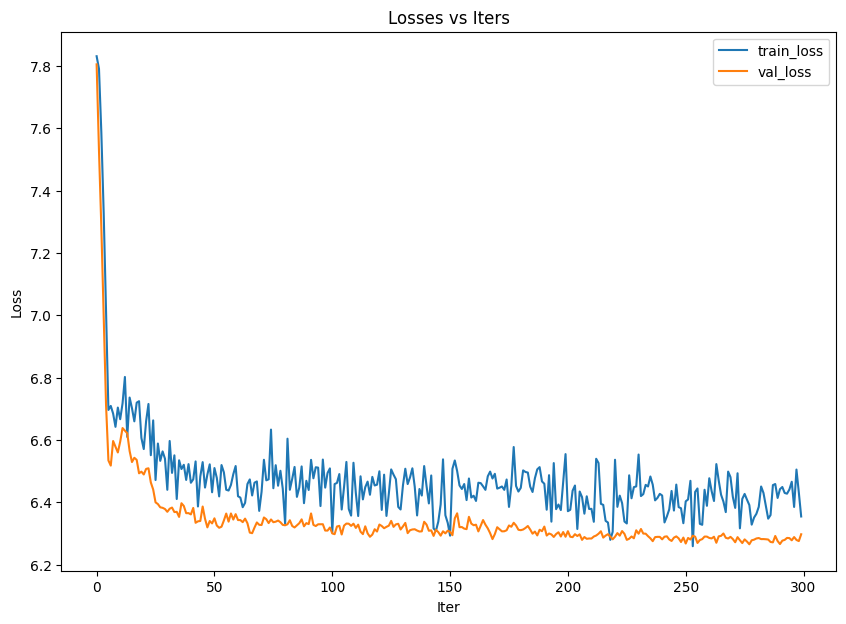

In [144]:
plot_loss_curves(results_2)

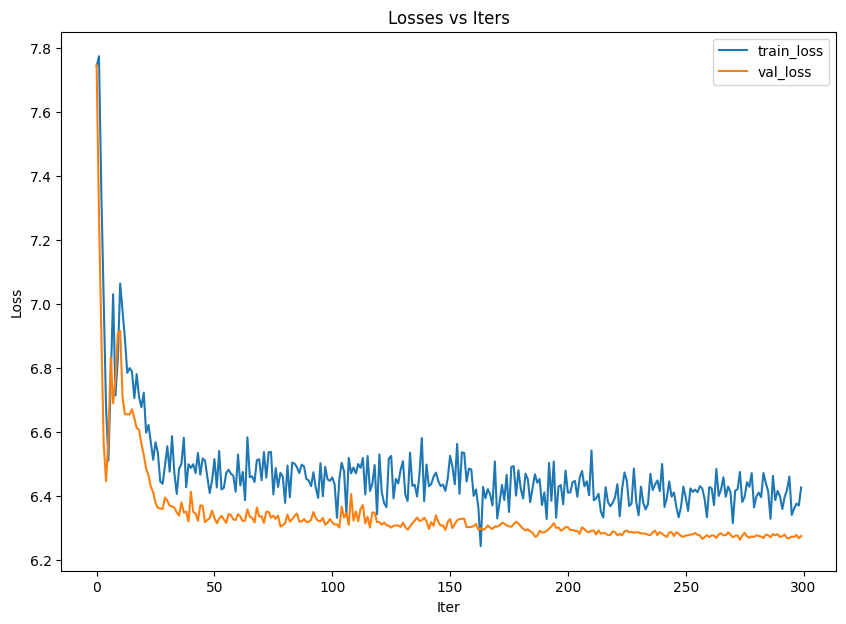

In [152]:
plot_loss_curves(results_2)

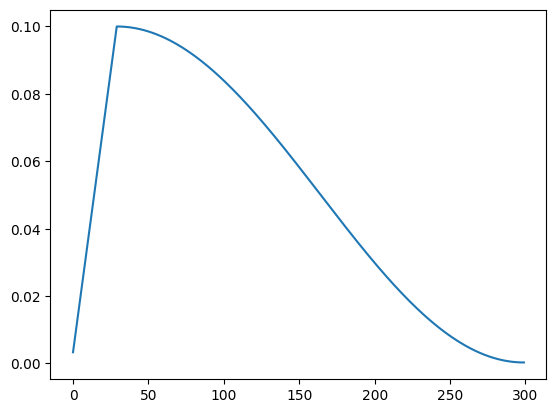

In [154]:
plt.plot(results_2['lrs']);

In [150]:
batch_size = 32
block_size = 64
n_embed = 128
num_heads = 4
head_size = None
num_blocks = 4
train_iters = 300
eval_iters = 100
summary(Model2())

Layer (type:depth-idx)                             Param #
Model2                                             --
├─DecoderOnlyTransformer: 1-1                      --
│    └─Embedding: 2-1                              262,144
│    └─Embedding: 2-2                              8,192
│    └─ModuleList: 2-3                             --
│    │    └─Block: 3-1                             197,888
│    │    └─Block: 3-2                             197,888
│    │    └─Block: 3-3                             197,888
│    │    └─Block: 3-4                             197,888
│    └─LayerNorm: 2-4                              256
│    └─Linear: 2-5                                 264,192
Total params: 1,326,336
Trainable params: 1,326,336
Non-trainable params: 0